adapted slightly from https://github.com/Djiffit/face-decoding-with-model-inversion

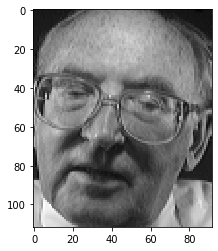

In [2]:
import torch
import os
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

classes = os.listdir('./data/processed/train')
c_to_i = lambda x: classes.index(x)
i_to_c = lambda x: classes[x]

transformer = transforms.Compose([
    transforms.ToTensor(),
])

def show_img(im):
    plt.imshow(im.reshape(112, 92) / 2 + .5, cmap='gray')
    plt.show()
    
def one_hot(x):
    vec = [0] *len(classes)
    vec[x] = 1
    return vec
    
train =test= 0
train_x, train_y = ([0]) * 360, ([0]) * 360
test_x, test_y = ([0]) * 40, ([0]) * 40
asd = []

for c in os.listdir('./data/processed/train/'):
    for faces in os.listdir('./data/processed/train/'+c):
        img = np.array(Image.open('./data/processed/train/'+c+'/'+faces).convert('L'))
        train_x[train] = (img).flatten()
        train_y[train] = (c_to_i(c))
        train += 1

for c in os.listdir('./data/processed/test/'):
    for faces in os.listdir('./data/processed/test/'+c):
        img = np.array(Image.open('./data/processed/test/'+c+'/'+faces).convert('L'))
        test_x[test] = img.flatten()
        test_y[test] = (c_to_i(c))
        test += 1

train_x = np.stack([x.flatten() for x in train_x])
test_x = np.stack([x.flatten() for x in test_x])
test_y = np.array(test_y,  dtype=np.int64)
train_y = np.array(train_y, dtype=np.int64)

show_img(train_x[0])

In [3]:
class FaceModel(torch.nn.Module):
    def __init__(self, D_in, D_out):
        super(FaceModel, self).__init__()
        
        self.linear1 = torch.nn.Linear(D_in, D_out)
        
    def forward(self,x):
        return self.linear1(x)

model = FaceModel(len(train_x[0]), len(classes))
    
steps = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=3e-1)

for i in range(steps):
    optimizer.zero_grad()
    y_hat = model(torch.Tensor(train_x))
    loss = criterion(y_hat, torch.LongTensor(train_y))
    loss.backward()
    optimizer.step()


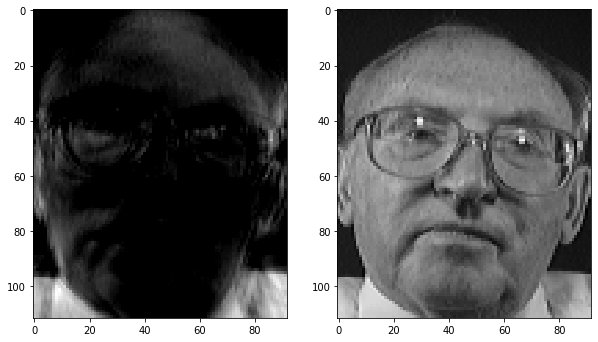

In [9]:
from scipy.ndimage import gaussian_filter, convolve
pred = ''
def invert(model, img, lr, c, best_loss, best_x, i):
    img = torch.Tensor(img).view(1, -1)
    if not img.requires_grad:
        img.requires_grad = True
        
    optimizer.zero_grad()
    pred = model(img)
    loss = criterion(pred, torch.LongTensor([c]))
    loss.backward()    
    img = torch.clamp(img - lr * img.grad, 0, 255)

    if loss.detach().numpy() < best_loss and i > 10:
        best_loss = loss.detach().numpy()
        best_x = img.detach().numpy()
        

    filt = np.array([
        [0,-1,0],
        [-1,5,-1],
        [0,-1,0]
    ])
    np_a = np.array([np.clip(x + np.random.normal(2, 2),0,255) for x in img.detach().numpy()])
    i = convolve(np_a.reshape(112, 92), filt)
    
    return best_loss, best_x, np_a.reshape(1, -1)
            
        
for c in classes:
    best_x,best_loss='',float('inf')
    img = np.zeros_like(train_x[0])
    for i in range(100):
        best_loss,best_x,img = invert(model, img, .01, c_to_i(c), best_loss, best_x, i)
    if c=='s34':
        fig = plt.figure(figsize=(10, 10))
        ax1 = fig.add_subplot(1,2,1)
        ax1.imshow(best_x.reshape(112, 92), cmap='gray')
        ax2 = fig.add_subplot(1,2,2)
        ax2.imshow(test_x[c_to_i(c)].reshape(112, 92), cmap='gray')
        # plt.savefig(f'./data/results/class {c}.png')
        plt.show()